### libs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.9 MB/s eta 0:00:00


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
import re
import contractions
import string
from bs4 import BeautifulSoup
# import requests
# from collections import Counter
# from num2words import num2words
from wordcloud import WordCloud, ImageColorGenerator
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
# import spacy
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import emoji
from emoji import demojize
import nltk
import warnings
warnings.filterwarnings("ignore")

# from nltk.corpus import stopwords
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('max_colwidth', 99999)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, ViTImageProcessor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

# Dataset

In [8]:
likable_data = pd.read_csv('/content/drive/MyDrive/ML Caption Craft/clean_data.csv', lineterminator='\n')

# Model - VisionEncoderDecoderModel

In [5]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 300

    def __len__(self, ):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.preprocessed_captions.iloc[idx]
        # print(caption)
        image = self.df.img_p.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                  padding='max_length',
                                  max_length=self.max_length, truncation=True).input_ids
        # print(len(captions))
        # print(captions)
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        # print(len(captions))
        # print(captions)
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        # print("Image size:", pixel_values.squeeze().size())
        # print("Caption size:", torch.tensor(captions).size())
        return encoding

In [6]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

In [7]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [13]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4624f7e08fbf818cfc9ab9f3ab478c5e5a3eb2d111edec54bff7138c3fd679fe
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


## Architecture

In [14]:
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
os.environ["WANDB_DISABLED"] = "true"
# configuration of training
class config :
    TRAIN_BATCH_SIZE = 10
    VAL_BATCH_SIZE = 10
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224, 224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

# rouge evaluation metric
rouge = datasets.load_metric("rouge")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer.pad_token = tokenizer.unk_token
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE),
        transforms.ToTensor()
   ]
)


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
# reading captions and the file names of images
# df = pd.read_csv("finetuned_captions.txt", on_bad_lines='skip') #further preprocessing on dataset.txt
train_df, val_df = train_test_split(likable_data[15000:16000], test_size=0.2)
# df.head()
# train and validation dataset

In [ ]:
train_dataset = ImgDataset(train_df, root_dir="/content/drive/MyDrive/ML Caption Craft/Likable Images", tokenizer=tokenizer, feature_extractor=feature_extractor, transform=transforms)
val_dataset = ImgDataset(val_df, root_dir="/content/drive/MyDrive/ML Caption Craft/Likable Images", tokenizer=tokenizer, feature_extractor=feature_extractor, transform=transforms)

In [ ]:
# !pip install accelerate
# # !pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
# model architecture
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
training_args = Seq2SeqTrainingArguments(
    output_dir='/content/drive/MyDrive/ML Caption Craft/VIT_large_gpt2_deep',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate=5e-5,
    num_train_epochs=config.EPOCHS,
    overwrite_output_dir=True,
    save_total_limit=1,
) #setting training parameters

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
model_directory = "/content/drive/MyDrive/ML Caption Craft/Image_Caption_Generator_10k_15k"
model = VisionEncoderDecoderModel.from_pretrained(model_directory)

In [ ]:
# from IPython.display import Image
# Image('ML Caption Craft/Likable Images/2008251914187139875.jpg')

In [ ]:
# !ls

## Training

In [ ]:
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
) #execute the finetuning
trainer.train()
# trainer.save_model("/content/drive/MyDrive/Image_Caption_Generator")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,3.205704,0.019900,0.041900,0.024400
2,No log,3.193133,0.016700,0.027500,0.017700
3,No log,3.180928,0.013400,0.019600,0.013700


TrainOutput(global_step=240, training_loss=3.398211669921875, metrics={'train_runtime': 1913.2663, 'train_samples_per_second': 1.254, 'train_steps_per_second': 0.125, 'total_flos': 4.331133386883072e+17, 'train_loss': 3.398211669921875, 'epoch': 3.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/ML Caption Craft/Image_Caption_Generator_15k_16k")

Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


# Predictions

In [15]:
model_directory = "/content/drive/MyDrive/ML Caption Craft/Image_Caption_Generator"
# tokenizer = AutoTokenizer.from_pretrained(model_directory)
# Load the saved model
model = VisionEncoderDecoderModel.from_pretrained(model_directory)



AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
os.environ["WANDB_DISABLED"] = "true"
# configuration of training
class config :
    TRAIN_BATCH_SIZE = 10
    VAL_BATCH_SIZE = 10
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224, 224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

# rouge evaluation metric
rouge = datasets.load_metric("rouge")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer.pad_token = tokenizer.unk_token


In [16]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [21]:
i = 17000
caption = likable_data.iloc[i].caption
preprocessed_captions = likable_data.iloc[i].preprocessed_captions
img_p = likable_data.iloc[i].img_p

In [22]:
root_dir= "/content/drive/MyDrive/ML Caption Craft/Likable Images"
path = os.path.join(root_dir, img_p)

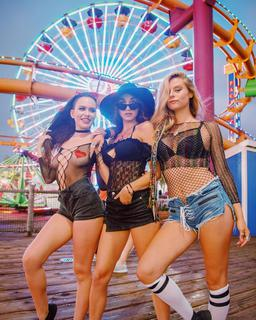

In [23]:
img =  Image.open(path).convert("RGB")
img

In [24]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
# generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values)[0])

generated_caption

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


"<|endoftext|>i am so excited to announce that we are partnering with    to launch a brand new line of women's swimwear   the line is called   and it is so cute and cute   it is a collaboration with  and i am so happy to be a part of it   you can shop all of my swimwear by following me on the liketoknow it app or via the link in my bio   swimwear from   are available for purchase on the  it app  or via link in bioconfusionconfusion   i have teamed up with two of my favorite swimwear"

In [25]:
caption

'California Love 🎡🎢🌅💕\n📸: @lizzierosemedia for @legavenue 💫\n#legavenue #santamonica #california #californialove'

In [26]:
likable_data['generated_caption'] = ''

In [27]:
len(likable_data)

17237

In [28]:
data = likable_data[16000:]

In [29]:
data.head()

,Unnamed: 0.1,Unnamed: 0,img_p,caption,preprocessed_captions,generated_caption
16000,16821,22350,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,
16001,16822,22351,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,
16002,16823,22352,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,
16003,16824,22353,1872175167322844074.jpg,"Today is a more appropriate time to pull out my plaid jumpsuit so yeah, welcome fall weather🍂🍂\nFollow me @liketoknow.it app under yourfrugalista to shop my daily looks.\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 http://liketk.it/2xpxi •\n•\n•\n#falllookbook #fallweatherishere #plaidjumpsuit #plaidpattern #preppylooks #preppygirlstyle #bostonfashionista #bostoninfluencers #ootdbostonian #boaterhat #newenglandliving #marshallsfinds #targetstyle",today is a more appropriate time to pull out my plaid jumpsuit so yeah welcome fall weather follow me it app under yourfrugalista to shop my daily looks,
16004,16825,22354,1877240015156943325.jpg,"I miss these buttoned up dresses when they were a trend in the summer but I think they fit for the fall too, don’t you agree? Wearing head to toe Target.\nHow to shop this look? Follow me @liketoknow.it app under yourfrugalista\n #liketkit #LTKshoecrush #LTKunder50 #LTKunder100 #LTKstyletip http://liketk.it/2xvjL •\n•\n•\n#falllookbook #buttonedupstyle #greenwithenvy #dresstoimpress #ootdboston #ootdbostonian #bucketbag #classystyles #bostonfashionblogger #mominaction #stylistmama #bostoninfluencer #targetstyle #targetdoesitagain",i miss these buttoned up dresse

In [30]:
data = likable_data[16000:]

In [31]:
def get_preds(row):
    caption = row['caption']
    preprocessed_captions = row.preprocessed_captions
    img_p = row.img_p
    root_dir= "/content/drive/MyDrive/ML Caption Craft/Likable Images"
    path = os.path.join(root_dir, img_p)
    img =  Image.open(path).convert("RGB")
    generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
    # print(generated_caption)
    return generated_caption

preds = []
for idx,row in tqdm(data.iterrows()):
    pred = get_preds(row)
    preds.append(pred)

data['generated_caption']=preds

0it [00:00, ?it/s]

In [32]:
data

,Unnamed: 0.1,Unnamed: 0,img_p,caption,preprocessed_captions,generated_caption
16000,16821,22350,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,<|endoftext|>i am so excited to finally be able to wear this dress it is so soft and cute i love how it is made i am wearing it on top of my dress and it is on the side of the tree i have been wearing it for a few days now and i am loving it shop your screenshot of this pic with the liketoknow it app or click the link in my bio to shop this look and others it also has a discount code for off this dress is from and is currently on sale you can shop my looks by following me on
16001,16822,22351,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,<|endoftext|>i am so excited to finally be able to share my story with you all i am so happy to have you all and thank you so much for taking the time to talk to me i hope you all are having a great time it is been a long time since i have been able to post on my blog but i am excited to share with you some of my favorite things i have seen in the past i have always been a big fan of and i am really excited to see what she is going to bring to the table she is a beautiful woman with a beautiful face and a beautiful
16002,16823,22352,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,<|endoftext|>i am so excited to finally be able to share my story with you all i am so happy to be a part of this amazing family i love you all so much and i hope you all have a great weekend i hope everyone is having a wonderful weekend thank you so much to everyon

In [33]:
data['generated_caption'] = data['generated_caption'].str.replace('<\|endoftext\|>','')

In [34]:
data.head(3)

,Unnamed: 0.1,Unnamed: 0,img_p,caption,preprocessed_captions,generated_caption
16000,16821,22350,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,i am so excited to finally be able to wear this dress it is so soft and cute i love how it is made i am wearing it on top of my dress and it is on the side of the tree i have been wearing it for a few days now and i am loving it shop your screenshot of this pic with the liketoknow it app or click the link in my bio to shop this look and others it also has a discount code for off this dress is from and is currently on sale you can shop my looks by following me on
16001,16822,22351,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,i am so excited to finally be able to share my story with you all i am so happy to have you all and thank you so much for taking the time to talk to me i hope you all are having a great time it is been a long time since i have been able to post on my blog but i am excited to share with you some of my favorite things i have seen in the past i have always been a big fan of and i am really excited to see what she is going to bring to the table she is a beautiful woman with a beautiful face and a beautiful
16002,16823,22352,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,i am so excited to finally be able to share my story with you all i am so happy to be a part of this amazing family i love you all so much and i hope you all have a great weekend i hope everyone is having a wonderful weekend thank you so much to everyone who has supported me in the past i ha

In [35]:
data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis =1,inplace=True)

In [36]:
 data.to_csv('/content/drive/MyDrive/ML Caption Craft/preds16k.csv', lineterminator='\n')

In [37]:
baseline_data = pd.read_csv('/content/drive/MyDrive/ML Caption Craft/baseline_1200.csv', lineterminator='\n')

In [38]:
all_preds = baseline_data.merge(data[['img_p','generated_caption']], how='left', on='img_p')
all_preds.head()

,Unnamed: 0,img_p,caption,preprocessed_captions,base_vit_gpt_caption,base_coca_caption,generated_caption
0,0,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,a woman wearing a hat standing next to a tree,a woman standing next to a tree in a park .,i am so excited to finally be able to wear this dress it is so soft and cute i love how it is made i am wearing it on top of my dress and it is on the side of the tree i have been wearing it for a few days now and i am loving it shop your screenshot of this pic with the liketoknow it app or click the link in my bio to shop this look and others it also has a discount code for off this dress is from and is currently on sale you can shop my looks by following me on
1,1,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,a woman standing in front of a brick wall wearing a pink dress,a woman standing on the side of a road wearing a dress .,i am so excited to finally be able to share my story with you all i am so happy to have you all and thank you so much for taking the time to talk to me i hope you all are having a great time it is been a long time since i have been able to post on my blog but i am excited to share with you some of my favorite things i have seen in the past i have always been a big fan of and i am really excited to see what she is going to bring to the table she is a beautiful woman with a beautiful face and a beautiful
2,2,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,a woman standing next to a fence with a hat on,a woman standing on the sidewalk wearing a hat .,i 

In [40]:
all_preds.drop(columns=['Unnamed: 0'], inplace=True)
all_preds.reset_index(inplace=True,drop=True)
all_preds.head(3)

,img_p,caption,preprocessed_captions,base_vit_gpt_caption,base_coca_caption,generated_caption
0,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,a woman wearing a hat standing next to a tree,a woman standing next to a tree in a park .,i am so excited to finally be able to wear this dress it is so soft and cute i love how it is made i am wearing it on top of my dress and it is on the side of the tree i have been wearing it for a few days now and i am loving it shop your screenshot of this pic with the liketoknow it app or click the link in my bio to shop this look and others it also has a discount code for off this dress is from and is currently on sale you can shop my looks by following me on
1,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,a woman standing in front of a brick wall wearing a pink dress,a woman standing on the side of a road wearing a dress .,i am so excited to finally be able to share my story with you all i am so happy to have you all and thank you so much for taking the time to talk to me i hope you all are having a great time it is been a long time since i have been able to post on my blog but i am excited to share with you some of my favorite things i have seen in the past i have always been a big fan of and i am really excited to see what she is going to bring to the table she is a beautiful woman with a beautiful face and a beautiful
2,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,a woman standing next to a fence with a hat on,a woman standing on the sidewalk wearing a hat .,i am so excited to 

In [41]:
 all_preds.to_csv('/content/drive/MyDrive/ML Caption Craft/ALL_PREDICTIONS_1200.csv', lineterminator='\n')

In [42]:
all_preds.head(50)

,img_p,caption,preprocessed_captions,base_vit_gpt_caption,base_coca_caption,generated_caption
0,1860421016364639460.jpg,"Am I the only one who’s still dressing up like summer? Well, I will try to enjoy these last couple hot days that we have here so yeah I don’t mind it at all☀️☀️\nT-shirt is from my Etsy store, click the link in my bio to shop.\nI’ve linked the rest of the outfit @liketoknow.it app by following me @yourfrugalista.\n #liketkit #LTKunder100 #LTKshoecrush #LTKunder50 http://liketk.it/2xcGs •\n•\n•\n#labordaylook #labordaystyle #ootdbostonian #denimskirts #graphicteeshirt #slogantees #etsysellers #etsymakers #chicnova #bostonfashionblogger #bostoninfluencers #womanentrepreneur #boaterhat #linenblazer #womanbussinessowner #tjmaxxfinds #targetstyle",am i the only one who is still dressing up like summer well i will try to enjoy these last couple hot days that we have here so yeah i do not mind it at all t shirt is from my etsy store click the link in my bio to shop i have linked the rest of the outfit it app by following me,a woman wearing a hat standing next to a tree,a woman standing next to a tree in a park .,i am so excited to finally be able to wear this dress it is so soft and cute i love how it is made i am wearing it on top of my dress and it is on the side of the tree i have been wearing it for a few days now and i am loving it shop your screenshot of this pic with the liketoknow it app or click the link in my bio to shop this look and others it also has a discount code for off this dress is from and is currently on sale you can shop my looks by following me on
1,1862029415539853473.jpg,"End of summer dress, it still feels like summer here so yes I haven’t featured any fall outfits on purpose, I would like to savor this moment as long as possible.\nFollow me @liketoknow.it free app to shop all my looks, search me under @yourfrugalista. #liketkit #LTKitbag #LTKunder100 #LTKunder50 #LTKshoecrush http://liketk.it/2xeva •\n•\n•\n#endofsummerseason #summerdressing #offtheshoulderdress #bostonfashionblogger #ootdbostonian #asianinfluencers #ootdfashionlook #ootdfashionindo #persueyourpassion #newenglandstyle #tjmaxxfinds #zarashoes #ebayfashion",end of summer dress it still feels like summer here so yes i have not featured any fall outfits on purpose i would like to savor this moment as long as possible follow me it free app to shop all my looks search me under,a woman standing in front of a brick wall wearing a pink dress,a woman standing on the side of a road wearing a dress .,i am so excited to finally be able to share my story with you all i am so happy to have you all and thank you so much for taking the time to talk to me i hope you all are having a great time it is been a long time since i have been able to post on my blog but i am excited to share with you some of my favorite things i have seen in the past i have always been a big fan of and i am really excited to see what she is going to bring to the table she is a beautiful woman with a beautiful face and a beautiful
2,1867147614090586401.jpg,"It’s actually cold enough to wear my camo jacket today and of course I pair it with my tee from my Etsy store. The sale is still going on guys, so check it out and don’t miss out!\nYou can shop all my looks @liketoknow.it free app, follow me under #yourfrugalista\n #liketkit #LTKunder50 #LTKstyletip #LTKunder100 #LTKxMFW http://liketk.it/2xk4P •\n•\n•\n#etsysales #etsymakers #graphicteeshirt #slogantshirt #supportsmallbusiness #camojackets #fallvibes #fallfashionista #ootdbostonian #stylecommunity #fashionlookbook #bostonfashionista #styleinthecity #tjmaxxfinds #primark",it is actually cold enough to wear my camo jacket today and of course i pair it with my tee from my etsy store the sale is still going on guys so check it out and do not miss out you can shop all my looks it free app follow me under,a woman standing next to a fence with a hat on,a woman standing on the sidewalk wearing a hat .,i am so excited to 

In [ ]:
3 . 1872175167322844074.jpg